# Cognitive Modelling: Homework 2
Name: Vishal Sreenivasan  
Student No.: S4196392

## Importing files & libraries

In [1]:
from model import Model
from dmchunk import Chunk
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# Time functions

In [2]:
def noise(s):
    rand = np.random.uniform(0.001,0.999)
    return s * math.log((1 - rand)/rand)

def time_to_pulses(time, t_0 = 0.011, a = 1.1, b = 0.015):
    pulses = 0
    pulse_duration = t_0
    while time >= pulse_duration:
        time = time - pulse_duration
        pulses += 1
        pulse_duration = a * pulse_duration + noise(b * a * pulse_duration)
    return pulses

def pulses_to_time(pulses, t_0 = 0.011, a = 1.1, b = 0.015):
    time = 0
    pulse_duration = t_0
    while pulses > 0:
        time = time + pulse_duration
        pulses = pulses - 1
        pulse_duration = a * pulse_duration + noise(b * a * pulse_duration)
    return time

In [8]:
def return_intervals():
    """
    function to return 
    sample intervals.
    """
    
    #reads J&S data
    df = pd.read_csv("dataJS.csv")
    
    #sorting the unique sample intervals on ascending order
    ts = np.sort(df["Ts"].unique())
    intervals = {"short": ts[0:11],
                "inter": ts[5:16],
                "long": ts[10:]}
    return intervals

def ready_set_go(n_participants, n_train = 500, n_test = 1000):
    """
    ready-set-go base function.
    
    Arguments:
    n_participants: number of participants.
    n_train: number of training steps.
    n_test: number of testing steps.
    """
    
    #intialize dataframe
    df = pd.DataFrame(columns = ["Subj", "Cond", "Trial", "Ts", "Tp", "Main"])
    
    #dataframe index
    index = 0
    
    #set number of trials
    trials = 1500
    
    #3 set of conditions
    conditions = ["short", "inter", "long"]
    
    #retrieving discrete interval distribution
    intervals = return_intervals()
    main = None
    
    for subj in range(n_participants):
        print(subj)
        
        #initializing new model for each participant
        
        #randomize conditions
        np.random.shuffle(conditions)
        
        for cond in conditions:
            
            m = Model()
            
            # Trial loop
            for trial in range(trials):
                
                #initial time
                m.time += 1
                main = True
                
                #random delay of 0.25-0.85 secs
                m.time += np.random.uniform(0.25,0.85)
                
                #randomly choosing a discrete interval
                interval = np.random.choice(intervals[cond])
                
                #converting secs to pulses
                pulse = time_to_pulses(interval/1000)
                
                #input chunk for dm
                fact = Chunk(name = f"rsg{pulse}", slots = {"isa": "rsg-time", "pulse": pulse})
                
                #adding the encounter and interval
                m.time += interval/1000
                m.add_encounter(fact)
                
                #additional time for go
                m.time += 0.010
                
                #request to retrive the pulse from dm
                request = Chunk(name = "blended-test", slots = {"isa": "rsg-time"})
                #retrieving the most activated memory
                pulse, latency = m.retrieve(request)
                m.add_encounter(pulse)
                
                #adding the latency and the production time
                m.time += latency
                time = pulses_to_time(pulse.slots["pulse"])
                m.time += time
                
                #appending to dataframe
                df.loc[index] = [subj + 1, cond, trial + 1, interval, time * 1000, main]
                index += 1
    return df

In [9]:
df = ready_set_go(5)

0
1
2
3
4


In [12]:
df.to_csv("hw3.csv", index = False)

# Plot function

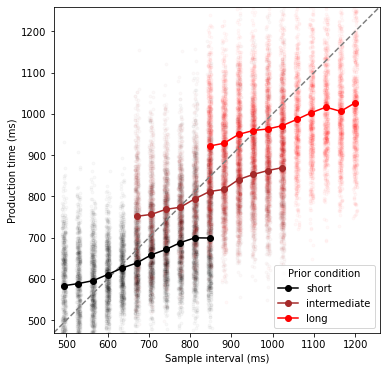

In [10]:
# Remove training trials
dat = df[df['Main'] == True]

# Calculate mean Tp by condition
mean_tp = dat.groupby(['Cond', 'Ts'])['Tp'].mean().reset_index()


yrange = np.multiply((min(mean_tp['Ts']), max(mean_tp['Ts'])), [0.95, 1.05])

# Subset data for plotting

cond1 = mean_tp.loc[mean_tp['Cond'] == "short"]
cond2 = mean_tp.loc[mean_tp['Cond'] == "inter"]
cond3 = mean_tp.loc[mean_tp['Cond'] == "long"]

# Add jitter noise
jitter = dat.copy()
jitter['Ts'] = jitter['Ts'] + np.random.uniform(-5, 5, len(dat))
cond1_jitter = jitter.loc[jitter['Cond'] == 'short']
cond2_jitter = jitter.loc[jitter['Cond'] == 'inter']
cond3_jitter = jitter.loc[jitter['Cond'] == 'long']

# Make plot
f, ax = plt.subplots(figsize = (6,6))

ax.set(xlim = yrange, ylim = yrange)
f.gca().set_aspect('equal', adjustable = 'box')

ax.set_xlabel('Sample interval (ms)')
ax.set_ylabel('Production time (ms)')

ax.plot(yrange, yrange, linestyle = '--', color ='gray')

ax.scatter(cond1_jitter['Ts'], cond1_jitter['Tp'], marker = '.', color = 'black', alpha = 0.025, label = None)
ax.scatter(cond2_jitter['Ts'], cond2_jitter['Tp'], marker = '.', color = 'brown', alpha = 0.025, label = None)
ax.scatter(cond3_jitter['Ts'], cond3_jitter['Tp'], marker = '.', color = 'red', alpha = 0.025, label = None)

ax.plot(cond1['Ts'], cond1['Tp'], color = 'black', marker = 'o', label = "short")
ax.plot(cond2['Ts'], cond2['Tp'], color = 'brown', marker = 'o', label = "intermediate")
ax.plot(cond3['Ts'], cond3['Tp'], color = 'red', marker = 'o', label = "long")

ax.legend(title = 'Prior condition', loc = 4)

# Conclusion

Previous homework deals with modelling J&S experiment where the sample time is assumed to be equal to the production time. This produces a diagonal with short, succeeded by inter and long intervals. In HW3, the production time is modelled after sample time, where the sample time is converted to pulses. Logistic noise is added to the time which causes a delay as the time is increased.  Retrieving the highest activated pulse denotes the ones which are stored over and over in the memory having a low latency. The production time for short range is almost diagonal, but the slope of  inter and long lines are low due to the increasing activation in the memory.

## To know:

Effects of lesser discrete time bins.